# Systrace Parser

In [1]:
import logging
from conf import LisaLogging
LisaLogging.setup()

2020-07-21 19:22:35,653 INFO    : root         : Using LISA logging configuration:
2020-07-21 19:22:35,654 INFO    : root         :   /home/ubuntu/Android/lisa_old/logging.conf


In [2]:
%pylab inline

import os
from time import sleep

# Support to access the remote target
import devlib
from env import TestEnv

# Import support for Android devices
from android import Screen, Workload

from devlib.utils.android import adb_command

# Support for trace events analysis
from trace import Trace

# Suport for FTrace events parsing and visualization
import trappy
import glob

import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from pandas import Series, DataFrame

import ipywidgets as widgets
from IPython.display import display

from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import Javascript, display

from android import System

import subprocess

from systrace_parser import systrace_parser

2020-07-21 19:22:35,928 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/Grammar.txt
2020-07-21 19:22:35,942 INFO    : root         : Generating grammar tables from /usr/lib/python2.7/lib2to3/PatternGrammar.txt


Populating the interactive namespace from numpy and matplotlib


## Test environment setup

**devlib** requires the ANDROID_HOME environment variable configured to point to your local installation of the Android SDK. If you have not this variable configured in the shell used to start the notebook server, you need to run a cell to define where your Android SDK is installed or specify the ANDROID_HOME in your target configuration.

In case more than one Android device are conencted to the host, you must specify the ID of the device you want to target in **my_target_conf**. Run **adb devices** on your host to get the ID.

In [3]:
import os
os.environ['ANDROID_HOME'] = '/home/ubuntu/Android/AndroidSDK/'

In [4]:
conf = {
    
    # Target platform and board
    "platform"    : 'android',
    "board"       : 'pixel',

    # Device ID
    #"device"      : "HT6670300102",
    
    # Android home
    "ANDROID_HOME" : "/home/ubuntu/Android/AndroidSDK",
    
    # Lisa home
    "LISA_HOME" : "/home/ubuntu/Android/lisa_old",

    # Systrace home
    "SYSTRACE_HOME" : "/ipynb/performance/testingdata",
    
    "MAX_CORE_NUM" : 8
}

In [5]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## Filters

In [6]:
trace_mark_filters = {
    'launching' : {
        'SMARK' : {'context' : 'launching:', 'type' : 'S'}, 
        'EMARK' : {'context' : 'launching:', 'type' : 'F'},
    },
    'ActivityThreadMain' : {
        'SMARK' : {'context' : 'ActivityThreadMain', 'type' : 'B'}, 
        'EMARK' : {'context' : 'ActivityThreadMain', 'type' : 'E'},
    },
    'bindApplication' : {
        'SMARK' : {'context' : 'bindApplication', 'type' : 'B'}, 
        'EMARK' : {'context' : 'bindApplication', 'type' : 'E'},
    },
    'activityStart' : {
        'SMARK' : {'context' : 'activityStart', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityStart', 'type' : 'E'},
    },
    'activityResume' : {
        'SMARK' : {'context' : 'activityResume', 'type' : 'B'}, 
        'EMARK' : {'context' : 'activityResume', 'type' : 'E'},
    },
    'Choreographer' : {
        'SMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'B'}, 
        'EMARK' : {'context' : 'Choreographer#doFrame', 'type' : 'E'},
        'SEPERATE' : [0, 1],
    },
    'setSurface' : {
        'SMARK' : {'context' : 'setSurface', 'type' : 'B'}, 
        'EMARK' : {'context' : 'setSurface', 'type' : 'E'},
    },
}

In [7]:
def MismatchedStringWithoutNumber(comp1, comp2):
    comp1 = unicode(comp1)
    comp2 = unicode(comp2)
    count = 0
    for index in range(min(len(comp1), len(comp2))):
        if comp1[index] != comp2[index] and not comp1[index].isnumeric() and not comp1[index].isnumeric():
            count += 1
            
    return count
#print(MismatchedStringWithoutNumber('A207FSH9_POS_190822_190822_104817_calllog?', 'A207FSH9_POS_190822_180922_104475_calllog1'))

## Select systraces

In [8]:

count = 0
dirname = ''
dirnames = ''
chboxes = list()
chboxes_descriptions = list()

for (path, dir, files) in os.walk(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/'):
    if len(dir) > 0:
        dirnames = dir
    file_groups = list()
    for filename in files:
        if filename.split('.')[-1] == 'html':
            filename = filename[:-5]
            #print(filename)
            new_one = True
            for file_group in file_groups:
                #length_of_file = len(filename)
                #if length_of_file == len(file_group) and filename[:length_of_file/2] == file_group[:length_of_file/2]:
                if not MismatchedStringWithoutNumber(filename, file_group):
                    #print('before  {}'.format(file_groups))
                    #if not file_group.contains('[?]'):
                    #    file_groups.remove(file_group)
                        #file_groups.append('{}?{}'.format(file_group[:-6],file_group[-5:]))
                    #    file_groups.append('{}[?]'.format(file_group[:-3]))
                        #print('after  {}'.format(file_groups))
                    new_one = False
                    break
            if new_one:
                file_groups.append(filename)

    for file_group in file_groups:
        chboxes_descriptions.append('{}{}'.format(dirname, file_group))
    if len(dirnames) > count:
        dirname = dirnames[count] + '/'
    else:
        dirname = ''
    count += 1
    
chboxes_descriptions.sort()
#display(chboxes_descriptions)
for chboxes_description in chboxes_descriptions:
        chboxes.append(widgets.Checkbox(
                value=False,
                description=chboxes_description.decode("utf-8"),
                disabled=False,
                layout=widgets.Layout(width="200%"),
                style={'description_width': 'initial'}
        ))

toggle = widgets.ToggleButton(
    description='START'
)

#chboxes[4].value = True
#chboxes[16].value = True

display(widgets.VBox(chboxes))

VkJveChjaGlsZHJlbj0oQ2hlY2tib3godmFsdWU9RmFsc2UsIGRlc2NyaXB0aW9uPXUnMTRJR1pVUC9hcXVlZHVjdHMnLCBsYXlvdXQ9TGF5b3V0KHdpZHRoPXUnMjAwJScpLCBzdHlsZT1EZXPigKY=


## Run cells

Please select over systrace files and press the run button to execute below cells.

In [11]:
def run_all(button):
    #get_ipython().run_cell()
    display(Javascript('IPython.notebook.execute_cells_below()'))

button = widgets.Button(description="Run all below")
button.on_click(run_all)
display(button)

<IPython.core.display.Javascript object>

Button(description=u'Run all below', style=ButtonStyle())

## Get file list

In [12]:
filelist = list()
title = list()

for chbox in chboxes:
    if chbox.value:
        #print(chbox.description)
        file_path = chbox.description.split('/')
        new_file_path = ''
        if len(file_path) > 1:
            for idx in range(len(file_path) - 1):
                new_file_path += file_path[idx] + '/'
        #length_of_file = len(file_path[-1])
        #new_file_path += file_path[-1][:-3] + '*.html'
        new_file_path += '*.html'
        #print(new_file_path)
        
        gathering_filelist = list()
        for dir_file in glob.glob(conf['LISA_HOME'] + conf['SYSTRACE_HOME'] + '/' + new_file_path):
            if not MismatchedStringWithoutNumber(file_path[-1], dir_file.split('/')[-1]):
                #print(dir_file)
                gathering_filelist.append(dir_file)
        filelist.append(gathering_filelist)
        #filelist[-1].sort()
        title += [file_path[-2] + "_" + file_path[-1]]

if len(filelist) == 0:
    raise  ValueError('Please select some groups of systrace in the over cell.')

Please select some systraces to analysis.

## Read Files

In [13]:
group1 = systrace_parser(trace_mark_filters, filelist[0], title[0])
group2 = systrace_parser(trace_mark_filters, filelist[1], title[1])

In [14]:
group1.run()
group2.run()

Parsing 10HAZFRE9_Alarm2.html - 47636 lines are Ok
Parsing 10HAZFRE9_Alarm3.html - 52532 lines are Ok
Parsing 10HAZFRE9_Alarm1.html - 55164 lines are Ok
Parsing 1BZGFSH9_c_lock2.html - 63374 lines are Ok
Parsing 1BZGFSH9_c_lock3.html - 62213 lines are Ok
Parsing 1BZGFSH9_c_lock1.html - 74570 lines are Ok


## Analysis

### The timing of marking data

The operation times of each trace_mark_filters.

In [15]:
list_of_df = group1.get_marking_time()
print(group1.title)
for df in list_of_df:
    display(df * 1000)

Clock_10HAZFRE9_Alarm2


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
3296.0,2.839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023.0,NaN,5.767,7.723,NaN,NaN,NaN,NaN,NaN
1451.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,456.621
2989.0,NaN,0.220,1.135,NaN,NaN,NaN,NaN,NaN
8783.0,3.180,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2416.0,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8754.0,NaN,273.131,29.901,NaN,120.401,NaN,NaN,NaN
1975.0,0.006,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1754.0,NaN,11.377,2.225,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
2977.0,NaN,0.289,1.204,NaN,NaN,NaN,NaN,NaN
8710.0,20.913,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3272.0,3.249,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025.0,NaN,1.017,8.563,NaN,NaN,NaN,NaN,NaN
8683.0,NaN,213.034,46.182,96.339,199.562,17.959,NaN,NaN
2415.0,0.298,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1458.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,493.528
1977.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1756.0,NaN,1.312,14.283,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
8770.0,5.325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8741.0,NaN,278.988,29.078,NaN,105.159,NaN,NaN,NaN
2025.0,NaN,5.116,8.162,NaN,NaN,NaN,NaN,NaN
2989.0,NaN,0.209,1.126,NaN,NaN,NaN,NaN,NaN
1456.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,451.869
1976.0,0.004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2419.0,0.380,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3352.0,4.357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1754.0,NaN,1.702,11.465,NaN,NaN,NaN,NaN,NaN


In [16]:
list_of_df = group2.get_marking_time()
print(group2.title)
for df in list_of_df:
    display(df * 1000)

Clock_1BZGFSH9_c_lock2


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1380.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,328.877
7633.0,NaN,93.898,19.205,NaN,98.505,NaN,12.494,NaN
2461.0,0.325,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1489.0,NaN,5.545,1.170,NaN,NaN,NaN,NaN,NaN
1490.0,NaN,0.691,0.509,NaN,NaN,NaN,NaN,NaN
7669.0,2.040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3103.0,NaN,0.171,1.382,NaN,NaN,NaN,NaN,NaN
1917.0,NaN,0.177,0.440,NaN,NaN,NaN,NaN,NaN
3615.0,1.673,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
1377.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,318.074
7810.0,NaN,93.684,16.043,NaN,87.073,NaN,12.624,NaN
3076.0,NaN,0.239,1.361,NaN,NaN,NaN,NaN,NaN
7845.0,1.784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1488.0,NaN,3.307,1.077,NaN,NaN,NaN,NaN,NaN
1489.0,NaN,0.770,0.479,NaN,NaN,NaN,NaN,NaN
1911.0,NaN,0.150,0.176,NaN,NaN,NaN,NaN,NaN
3547.0,1.779,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2463.0,0.260,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
pid,,,,,,,,
7684.0,27.918,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2437.0,0.477,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078.0,NaN,0.290,1.835,NaN,NaN,NaN,NaN,NaN
1391.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,756.563
1488.0,NaN,0.727,0.415,NaN,NaN,NaN,NaN,NaN
1914.0,NaN,0.178,0.211,NaN,NaN,NaN,NaN,NaN
1487.0,NaN,2.931,2.017,NaN,NaN,NaN,NaN,NaN
7644.0,NaN,140.657,44.939,138.833,248.276,68.461,49.018,NaN
3551.0,1.447,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Launching Time(AVERAGE)

This section is showing the app launching time.

In [17]:
list_of_df = group1.get_marking_time()
sum_df1 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]

    if len(get_launching.index) :
        try :
            sum_df1 = pd.concat([sum_df1, get_launching])
        except :
            sum_df1 = get_launching

try :
    sum_df1 = sum_df1.replace(0, NaN).dropna(axis=1) * 1000
    sum_df1.loc['mean'] = sum_df1.mean()
except:
    print("No launching time")
    
list_of_df = group2.get_marking_time()
sum_df2 = None

for df in list_of_df:
    get_launching = df[df['launching'] > 0]
    
    if len(get_launching.index) :
        try :
            sum_df2 = pd.concat([sum_df2, get_launching])
        except :
            sum_df2 = get_launching

try :
    sum_df2 = sum_df2.replace(0, NaN).dropna(axis=1) * 1000
    sum_df2.loc['mean'] = sum_df2.mean()
except:
    print("No launching time")

In [18]:
display(pd.concat([sum_df1, sum_df2], keys=[group1.title, group2.title], sort=False))

launching
                       pid               
Clock_10HAZFRE9_Alarm2 1451.0  456.621000
                       1458.0  493.528000
                       1456.0  451.869000
                       mean    467.339333
Clock_1BZGFSH9_c_lock2 1380.0  328.877000
                       1377.0  318.074000
                       1391.0  756.563000
                       mean    467.838000

### Process Time(AVERAGE)

Process time is from start to end timing within systrace tag of binadApplication / activityStart / ActivityThreadMain / ActivityResume.
 - time : total sum of time of running / runnable / sleeping / uninterruptible sleep.
 - running / runnable / sleeping / uninterruptible sleep : Process stat of cores.
 - setSurface : Just test and check the length of setSurface's tags.
 - launching : Sum of each tags, bindApplication, activityStart, ActivityThreadMain, activityResume, and Choreographer.

In [19]:
df1 = group1.get(systrace_parser.process_state()) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(systrace_parser.process_state()) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [20]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

setSurface  \
Clock_10HAZFRE9_Alarm2 time                                0   
                       RUNNING                             0   
                       RUNNABLE                            0   
                       SLEEPING                            0   
                       UNINTERUPTIBLE_SLEEP                0   
                       UNINTERUPTIBLE_SLEEP(I/O)           0   
Clock_1BZGFSH9_c_lock2 time                                0   
                       RUNNING                             0   
                       RUNNABLE                            0   
                       SLEEPING                            0   
                       UNINTERUPTIBLE_SLEEP                0   
                       UNINTERUPTIBLE_SLEEP(I/O)           0   
DIFF                   time                                0   
                       RUNNING                             0   
                       RUNNABLE                            0   
                       SLEEPING                            0   
                       UNINTERUPTIBLE_SLEEP                0   
                       UNINTERUPTIBLE_SLEEP(I/O)           0   

                                                  Choreographer #0  \
Clock_10HAZFRE9_Alarm2 time                                255.051   
                       RUNNING                             197.562   
                       RUNNABLE                             11.944   
                       SLEEPING                             43.025   
                       UNINTERUPTIBLE_SLEEP                  0.205   
                       UNINTERUPTIBLE_SLEEP(I/O)             2.315   
Clock_1BZGFSH9_c_lock2 time                                109.413   
                       RUNNING                              81.418   
                       RUNNABLE                              8.663   
                       SLEEPING                             12.598   
                       UNINTERUPTIBLE_SLEEP                  0.043   
                       UNINTERUPTIBLE_SLEEP(I/O)             6.691   
DIFF                   time                                145.638   
                       RUNNING                             116.144   
                       RUNNABLE                              3.281   
                       SLEEPING                             30.427   
                       UNINTERUPTIBLE_SLEEP                  0.162   
                       UNINTERUPTIBLE_SLEEP(I/O)            -4.376   

                                                  Choreographer #1  \
Clock_10HAZFRE9_Alarm2 time                                 35.054   
                       RUNNING                              13.910   
                       RUNNABLE                              0.518   
                       SLEEPING                             20.626   
                       UNINTERUPTIBLE_SLEEP                  0.000   
                       UNINTERUPTIBLE_SLEEP(I/O)             0.000   
Clock_1BZGFSH9_c_lock2 time                                 26.729   
                       RUNNING                               7.833   
                       RUNNABLE                              0.063   
                       SLEEPING                             18.499   
                       UNINTERUPTIBLE_SLEEP                  0.000   
                       UNINTERUPTIBLE_SLEEP(I/O)             0.334   
DIFF                   time                                  8.325   
                       RUNNING                               6.077   
                       RUNNABLE                              0.455   
                       SLEEPING                              2.127   
                       UNINTERUPTIBLE_SLEEP                  0.000   
                       UNINTERUPTIBLE_SLEEP(I/O)            -0.334   

                                                  bindApplication  \
Clock_10HAZFRE9_Alarm2 time                                     0   
                       RUNNING   

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
Clock_10HAZFRE9_Alarm2,time,0,255.051,35.054,0,141.707,0,0.000,0
Clock_1BZGFSH9_c_lock2,time,0,109.413,26.729,0,144.618,0,24.712,0
DIFF,time,0,145.638,8.325,0,-2.911,0,-24.712,0


### Processing time of setSurface

In [21]:
def ProcessingTime(group, index):
    result = dict()
    list_of_df = group.get_marking_time()
    sum = 0
    count = 0
    for df in list_of_df:
        df = df['setSurface'].fillna(0)
        max_value = df.max() * 1000
        sum += max_value
        count += 1
        result[count] = [max_value]
    #print("SUM : {}, AVG : {}".format(sum, sum/count))
    result['avg'] = [sum/count]
    
    df = DataFrame.from_dict(result)
    df.index = [group.title]
    return df

In [22]:
df1 = ProcessingTime(group1, 'setSurface')
df2 = ProcessingTime(group2, 'setSurface')
display(pd.concat([df1, df2]))

,1,2,3,avg
Clock_10HAZFRE9_Alarm2,3.18,20.913,5.325,9.806000
Clock_1BZGFSH9_c_lock2,2.04,1.784,27.918,10.580667


### Uninterruptible Sleep

The count of uninterruptible sleep within each tags.

In [23]:
index1 = group1.unint_sleep()
index2 = group2.unint_sleep()
union_index = index1
for index in index2:
    if not index in union_index:
        union_index += [index]

union_index.sort()
        
df1 = group1.get(union_index, func='avg').sort_index()
df1 = df1.dropna(axis=1)

df2 = group2.get(union_index, func='avg').sort_index()
df2 = df2.dropna(axis=1)

In [24]:
print(group1.title)
display(df1)

Clock_10HAZFRE9_Alarm2


,Choreographer #0,Choreographer #1,activityStart
uninter_reason//SyS_mprotect+0xc0/0x208,0.666667,0.0,0.000000
uninter_reason//SyS_munmap+0x30/0x6c,0.000000,0.0,0.000000
uninter_reason//do_mprotect_pkey+0x98/0x22c,0.000000,0.0,0.000000
uninter_reason//do_page_fault+0x22c/0x48c,0.000000,0.0,0.000000
uninter_reason//do_page_fault+0xe0/0x2ec,2.333333,0.0,0.000000
uninter_reason//vm_mmap_pgoff+0x74/0xe0,1.000000,0.0,0.000000
uninter_reason//vm_mmap_pgoff+0xa4/0xf4,0.000000,0.0,0.000000
uninter_reason//vm_munmap+0x30/0x60,1.000000,0.0,0.000000
uninter_reason_io//__lock_page_killable+0x70/0x90,1.333333,0.0,1.666667
uninter_reason_io//__lock_page_or_retry+0x118/0x15c,0.000000,0.0,0.000000


In [25]:
print(group2.title)
display(df2)

Clock_1BZGFSH9_c_lock2


,Choreographer #0,Choreographer #1,activityStart,activityResume
uninter_reason//SyS_mprotect+0xc0/0x208,0.000000,0.000000,0.000000,0.000000
uninter_reason//SyS_munmap+0x30/0x6c,0.333333,0.000000,0.000000,0.000000
uninter_reason//do_mprotect_pkey+0x98/0x22c,0.000000,0.000000,0.000000,0.000000
uninter_reason//do_page_fault+0x22c/0x48c,0.666667,0.000000,1.333333,0.666667
uninter_reason//do_page_fault+0xe0/0x2ec,0.000000,0.000000,0.000000,0.000000
uninter_reason//vm_mmap_pgoff+0x74/0xe0,0.000000,0.000000,0.000000,0.000000
uninter_reason//vm_mmap_pgoff+0xa4/0xf4,1.333333,0.000000,0.666667,0.000000
uninter_reason//vm_munmap+0x30/0x60,0.000000,0.000000,0.000000,0.000000
uninter_reason_io//__lock_page_killable+0x70/0x90,0.000000,0.000000,0.000000,0.000000
uninter_reason_io//__lock_page_or_retry+0x118/0x15c,3.000000,0.333333,18.666667,0.000000


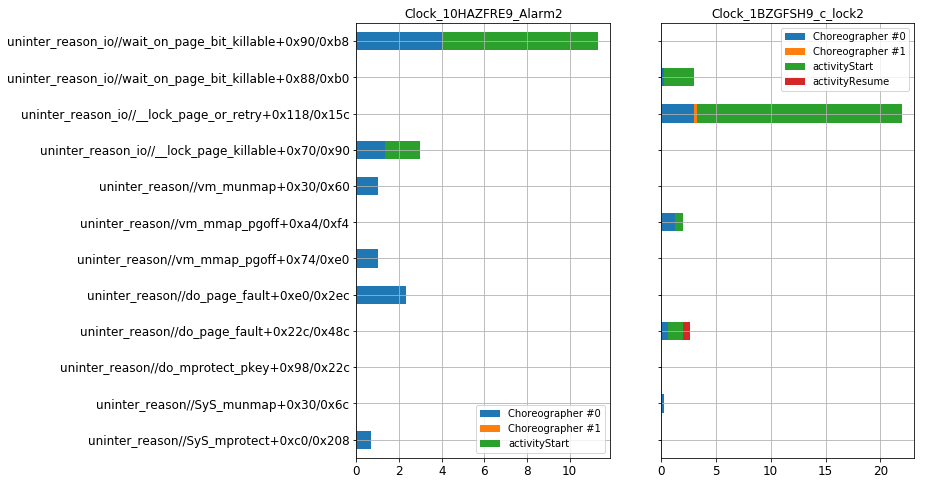

In [26]:
fig,axes = plt.subplots(nrows=1, ncols=2, sharey=True)
df1.plot(kind='barh', ax=axes[0], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group1.title)
df2.plot(kind='barh', ax=axes[1], figsize=(10,8), grid=True, fontsize=12, stacked=True, title=group2.title)

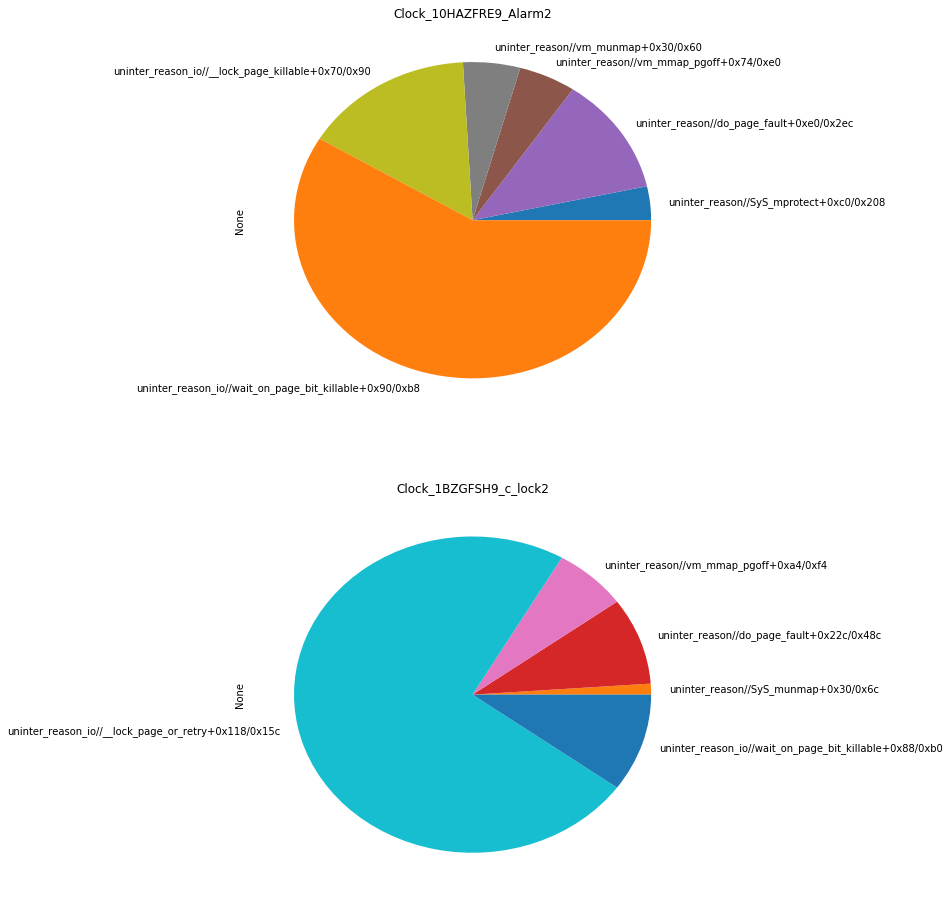

In [27]:
fig,axes = plt.subplots(nrows=2, ncols=1, sharey=True)
df1.sum(axis=1).plot(kind='pie', ax=axes[0], figsize=(8,16), title=group1.title)
df2.sum(axis=1).plot(kind='pie', ax=axes[1], figsize=(8,16), title=group2.title)

The number of count in each reason of uninterruptible sleep.

### Number of Running Cores(SUM)

The number of counting running cores when entering an app.

In [28]:
df1 = group1.get(group1.cores(), func='sum')
df1 = df1.dropna(axis=1)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(group2.cores(), func='sum')
df2 = df2.dropna(axis=1)
df2.columns.name = group2.title
#display(df2)

In [29]:
display(pd.concat([df1, df2], keys=[group1.title, group2.title], sort=False))

Choreographer #0  Choreographer #1  \
Clock_10HAZFRE9_Alarm2 core0                12                 0   
                       core1                 4                 0   
                       core2                10                 0   
                       core3                 2                 0   
                       core4               124                12   
                       core5                86                 1   
                       core6                62                 4   
                       core7                52                 8   
Clock_1BZGFSH9_c_lock2 core0                 5                 1   
                       core1                 0                 1   
                       core2                 1                 0   
                       core3                 0                 0   
                       core4                30                 0   
                       core5                25                 4   
                       core6                22                 4   
                       core7                17                 0   

                              activityStart  activityResume  
Clock_10HAZFRE9_Alarm2 core0             23             NaN  
                       core1              9             NaN  
                       core2              4             NaN  
                       core3             11             NaN  
                       core4             63             NaN  
                       core5             41             NaN  
                       core6             45             NaN  
                       core7             41             NaN  
Clock_1BZGFSH9_c_lock2 core0              3             4.0  
                       core1              8             1.0  
                       core2              2            10.0  
                       core3             11             1.0  
                       core4             49             8.0  
                       core5             32            14.0  
                       core6             63            16.0  
                       core7             18             1.0

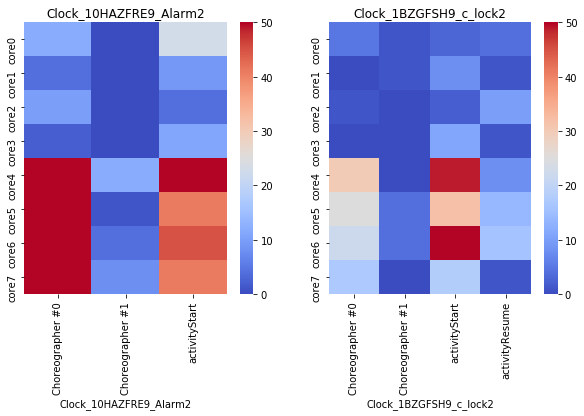

In [30]:
plt.figure(figsize=(10, 5))
#sb.palplot(sb.color_palette("hls", 8))
subplot(1,2,1, title=group1.title)
sb.heatmap(data=df1, cmap='coolwarm', center=25, vmax = 50);
subplot(1,2,2, title=group2.title)
sb.heatmap(data=df2, cmap='coolwarm', center=25, vmax = 50);

In [31]:
print(group1.title)
for parser in group1.parsers_of_testing:
    display(parser.get(group1.cores()))

1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,2,0,0,1,NaN
core1,NaN,0,2,5,0,0,0,NaN
core2,NaN,0,0,4,0,1,0,NaN
core3,NaN,1,0,4,0,0,0,NaN
core4,NaN,0,0,1,0,0,0,NaN
core5,NaN,0,0,9,0,0,0,NaN
core6,NaN,17,17,164,60,0,1,NaN
core7,NaN,18,24,177,45,3,22,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,8,0,0,1,NaN
core1,NaN,1,0,7,0,0,1,NaN
core2,NaN,0,0,2,1,1,2,NaN
core3,NaN,0,0,3,0,0,0,NaN
core4,NaN,0,0,0,0,0,0,NaN
core5,NaN,0,0,3,0,0,0,NaN
core6,NaN,6,0,106,61,0,7,NaN
core7,NaN,32,1,233,59,4,14,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,0,1,0,0,NaN
core1,NaN,0,0,1,2,0,0,NaN
core2,NaN,0,0,1,0,0,2,NaN
core3,NaN,2,0,1,2,0,0,NaN
core4,NaN,1,0,1,2,0,1,NaN
core5,NaN,0,0,5,2,0,1,NaN
core6,NaN,14,0,40,50,2,10,NaN
core7,NaN,25,1,33,59,1,14,NaN


In [32]:
print(group2.title)
for parser in group2.parsers_of_testing:
    display(parser.get(group2.cores()))

1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,2,6,0,3,NaN
core1,NaN,0,0,5,0,0,0,NaN
core2,NaN,0,0,1,3,0,1,NaN
core3,NaN,2,0,1,2,0,1,NaN
core4,NaN,26,0,13,13,4,10,NaN
core5,NaN,12,0,28,19,2,4,NaN
core6,NaN,4,1,1,14,0,3,NaN
core7,NaN,11,0,4,37,0,12,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,3,3,0,3,NaN
core1,NaN,1,0,1,4,0,1,NaN
core2,NaN,1,0,0,4,0,1,NaN
core3,NaN,0,0,1,2,0,0,NaN
core4,NaN,15,0,15,15,2,4,NaN
core5,NaN,7,0,11,26,1,1,NaN
core6,NaN,12,0,21,13,0,13,NaN
core7,NaN,14,1,3,28,0,5,NaN


,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
core0,NaN,0,0,4,5,0,2,NaN
core1,NaN,0,0,0,1,0,1,NaN
core2,NaN,0,0,0,4,0,0,NaN
core3,NaN,0,0,0,2,0,0,NaN
core4,NaN,25,0,13,31,3,14,NaN
core5,NaN,3,0,25,25,0,7,NaN
core6,NaN,13,0,8,6,0,0,NaN
core7,NaN,9,1,0,29,0,7,NaN


In [33]:
from systrace_parser import TAG_CORE_IDLE
def GetCoreStats(group):
    for parser in group.parsers_of_testing:
        rawdata = parser.get_rawdata('stat_core')
        index_key_list = list()
        df_list = list()
        
        for index_key in rawdata.keys():
            #print(index_key)
            index_key_list.append(index_key)

            core_state_dict = dict()
            for i in range(8):
                core_state_dict[i] = list()
            core_state_dict['selected'] = list()
            core_state_dict['time'] = list()

            for core_state in rawdata[index_key]:
                for i in range(8):
                    core_state_dict[i].append(core_state.get(i, TAG_CORE_IDLE))
                core_state_dict['selected'].append(core_state.get('selected', -1))
                core_state_dict['time'].append(core_state.get('time', -1))
            #display(DataFrame.from_dict(core_state_dict))
            df_list.append(DataFrame.from_dict(core_state_dict))

    return pd.concat(df_list, keys=index_key_list, sort=False).sort_values(by=['time'])
pd.set_option('display.max_rows', 500)

In [34]:
print(group1.title)
display(GetCoreStats(group1))

1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  R  I  R  R  I  V  I         6  317.461711
                   1    I  R  R  I  R  I  V  I         6  317.462260
                   2    R  R  I  R  I  R  V  R         6  317.470903
bindApplication    0    I  R  I  I  I  R  R  V         7  317.476319
                   1    R  R  I  I  I  I  R  V         7  317.476584
                   2    R  R  I  I  I  I  R  V         7  317.477377
                   3    R  I  I  I  I  I  I  V         7  317.477718
                   4    I  I  I  I  I  I  I  V         7  317.482158
                   5    R  I  I  I  I  I  I  V         7  317.482695
                   6    I  I  I  I  I  I  I  V         7  317.484859
                   7    R  I  I  I  I  I  R  V         7  317.487403
                   8    I  I  I  I  I  I  I  V         7  317.488372
                   9    I  I  I  I  I  R  I  V         7  317.489117
                   10   I  I  I  I  I  I  I  V         7  317.491820
                   11   R  I  R  I  I  I  I  V         7  317.491926
                   12   R  R  I  I  I  R  I  V         7  317.492291
                   13   R  I  R  I  I  R  I  V         7  317.497614
                   14   R  I  I  I  I  R  I  V         7  317.497736
                   15   R  R  I  I  I  R  I  V         7  317.498181
                   16   I  I  I  R  I  I  I  V         7  317.505263
                   17   R  R  R  R  I  I  I  V         7  317.506012
                   18   I  R  R  R  I  I  I  V         7  317.506530
                   19   I  I  I  I  I  I  I  V         7  317.507300
                   20   I  I  I  I  I  V  I  I         5  317.509098
                   21   R  I  I  R  I  V  R  I         5  317.511271
                   22   I  I  I  R  I  V  R  I         5  317.512196
                   23   I  I  I  R  I  V  I  R         5  317.513916
                   24   I  I  I  R  I  V  I  I         5  317.514804
                   25   I  I  I  I  I  I  V  I         6  317.516983
                   26   I  I  I  I  I  I  V  I         6  317.520131
                   27   I  I  I  I  I  I  V  I         6  317.524683
                   28   I  I  I  I  I  I  V  I         6  317.528525
                   29   I  I  I  I  R  I  V  I         6  317.528806
                   30   R  I  I  I  I  I  V  R         6  317.529045
                   31   I  I  I  I  I  I  V  R         6  317.529957
                   32   R  R  I  I  I  I  V  I         6  317.531004
                   33   I  R  I  I  I  I  V  R         6  317.532093
                   34   I  I  I  I  I  R  V  I         6  317.533995
                   35   I  I  I  I  I  I  V  I         6  317.534400
                   36   I  I  I  I  I  I  V  I         6  317.535347
                   37   I  I  I  I  I  I  V  I         6  317.536083
                   38   I  R  I  I  I  R  V  I         6  317.537500
                   39   I  I  I  I  R  I  V  I         6  317.538079
                   40   I  I  I  I  I  I  V  I         6  317.538420
                   41   I  I  I  I  I  I  V  I         6  317.538738
                   42   I  R  I  I  I  I  V  I         6  317.539045
                   43   I  I  I  I  I  I  V  I         6  317.539431
                   44   I  I  I  I  I  I  V  I         6  317.539970
                   45   I  I  I  I  I  R  V  I         6  317.542726
                   46   R  R  R  R  I  R  V  I         6  317.545976
                   47   I  R  I  I  R  R  V  R         6  317.546715
                   48   I  I  R  I  I  I  V  R         6  317.549071
                   49   R  R  R  R  I  I  V  I         6  317.550176
                   50   I  I  I  R  I  I  V  I         6  317.550543
                   51   R  R  I  I  I  I  I  V         7  317.553571
                   52   R  R  I  R  I  I  V  I         6  317.553771
                   53   R  R  R  I  I  I  V  I         6  317.554113
                   54 

In [35]:
print(group2.title)
display(GetCoreStats(group2))

1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note


0  1  2  3  4  5  6  7  selected        time
ActivityThreadMain 0    I  R  I  I  V  I  I  I         4  325.335638
                   1    I  R  I  I  V  I  I  I         4  325.336309
                   2    I  I  R  I  R  I  V  I         6  325.344881
bindApplication    0    V  R  R  I  I  I  I  I         0  325.346336
                   1    R  I  R  I  I  V  I  I         5  325.346427
                   2    I  I  R  I  R  V  I  I         5  325.346658
                   3    I  I  R  I  R  V  I  I         5  325.347377
                   4    I  I  R  I  R  V  I  I         5  325.347608
                   5    I  I  R  I  R  V  I  I         5  325.352723
                   6    I  I  R  I  R  V  I  I         5  325.354391
                   7    I  I  R  I  R  V  I  I         5  325.356048
                   8    I  I  I  I  I  V  I  I         5  325.361504
                   9    I  I  R  I  R  V  I  I         5  325.374149
                   10   I  I  R  I  R  V  I  I         5  325.374180
                   11   I  I  R  I  R  V  R  I         5  325.374207
                   12   I  I  I  I  R  V  R  I         5  325.378417
                   13   I  I  I  I  R  V  R  I         5  325.381412
                   14   R  I  I  I  R  V  R  I         5  325.381722
                   15   I  I  I  I  R  V  R  I         5  325.382118
                   16   I  I  I  I  R  V  I  I         5  325.382817
                   17   V  I  R  I  R  R  R  I         0  325.387920
                   18   I  R  R  I  R  R  V  I         6  325.387977
                   19   R  R  R  I  V  I  R  I         4  325.389374
                   20   I  I  I  I  V  R  R  I         4  325.393191
                   21   R  R  I  I  V  R  R  I         4  325.394477
                   22   I  I  I  I  V  R  R  I         4  325.395442
                   23   R  I  I  I  R  V  I  I         5  325.395830
                   24   I  I  I  I  V  R  R  I         4  325.396396
                   25   R  I  R  I  R  V  I  I         5  325.398220
                   26   I  I  I  I  R  V  R  I         5  325.398718
                   27   I  I  I  I  R  V  I  I         5  325.400318
                   28   I  I  I  I  R  V  I  I         5  325.400445
                   29   I  R  I  I  R  V  I  I         5  325.400536
                   30   V  I  R  I  I  R  R  R         0  325.401428
                   31   V  I  I  I  R  I  I  R         0  325.403865
                   32   I  R  R  R  V  I  R  R         4  325.406331
                   33   I  R  I  I  V  I  I  I         4  325.414494
                   34   I  R  I  I  R  I  V  I         6  325.415903
                   35   I  R  I  R  I  R  V  I         6  325.416637
                   36   I  R  I  I  R  V  R  R         5  325.417496
                   37   I  I  R  I  R  V  I  R         5  325.417652
                   38   I  I  I  R  R  V  R  R         5  325.418333
                   39   I  R  I  I  V  R  I  R         4  325.419188
                   40   I  I  I  R  V  I  I  R         4  325.420188
                   41   I  I  I  I  V  I  I  R         4  325.420795
                   42   I  R  I  I  V  I  I  R         4  325.426473
                   43   I  I  I  I  R  R  V  R         6  325.428173
                   44   R  I  I  I  R  R  V  I         6  325.434059
                   45   R  I  I  R  I  R  V  I         6  325.439703
                   46   R  R  R  R  R  I  V  R         6  325.444678
                   47   I  R  R  I  V  I  I  R         4  325.445046
                   48   I  R  R  I  V  R  R  R         4  325.452149
                   49   R  R  I  R  I  R  V  R         6  325.455565
activityStart      0    R  I  R  R  I  R  V  R         6  325.456578
                   1    I  I  I  R  I  I  I  V         7  325.458660
                   2    I  I  I  I  R  R  I  V         7  325.463383
                   3    R  R  I  R  V  R  I  I         4  325.464332
                   4  

### Cpu Frequency

The graph to show a min lock status of core frequency.

In [36]:
from systrace_parser import CPU_FREQUENCY_LIMITS
def DrawCorrectedData(group, tyep_filter, data_label, func):
    prevalue = dict()
    list_of_df_for_start = group.get_marking_time(dtype='start')
    list_of_df_for_end = group.get_marking_time(dtype='end')
    idx = 0

    for item in group.get(tyep_filter, func='array'):
        df = DataFrame(item, columns=['cpu_id', 'time', data_label])
        df = df.apply(pd.to_numeric)
        
        ### to darw launcging time ++
        min_freq = df[data_label].min()
        prevalue['launching'] = min_freq
        
        if len(list_of_df_for_start) > idx:
            launching_time = list_of_df_for_start[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time, 
                           data_label : ((min_freq + 1) * 2)}, ignore_index=True) 
        if len(list_of_df_for_end) > idx:
            launching_time = list_of_df_for_end[idx]['launching'].max()
            if launching_time > 0:
                df = df.append({'cpu_id' : 'launching', 
                           'time' : launching_time,
                           data_label : min_freq}, ignore_index=True)
        ### to darw launcging time --
        
        if func != 0:
            df = func(df)
            
        length = len(df.index)
            
        for i in range(length):
            #display(df.iloc[i])
            if df.iloc[i]['cpu_id'] in prevalue.keys():
                df = df.append({'cpu_id' : df.iloc[i]['cpu_id'], 
                           'time' : (df.iloc[i]['time'] - 0.000001), 
                           data_label : prevalue[df.iloc[i]['cpu_id']]}, ignore_index=True) 
                #display(df.iloc[i])
            prevalue[df.iloc[i]['cpu_id']] = df.iloc[i][data_label]
        
        idx += 1
        df.index = df['time']
        df = df.sort_index()
        df.groupby(['cpu_id'])[data_label].plot(legend=True, figsize=(15,4))
        plt.show()

1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note


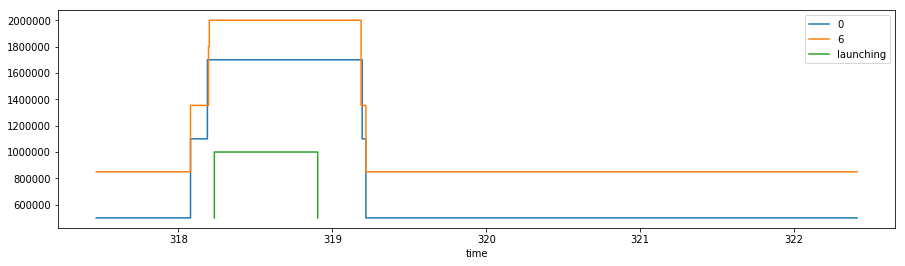

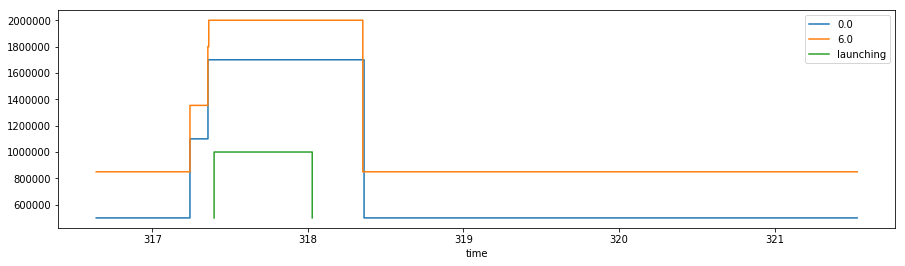

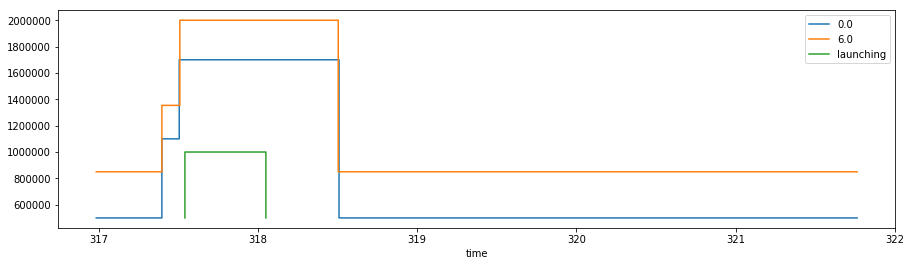

In [37]:
print(group1.title)
DrawCorrectedData(group1, CPU_FREQUENCY_LIMITS, 'min', 0)

1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']
ERROR!!!   - parser_range::get() - columns has no the item
           - item : cpu_frequency_limits:
           - result_cores.keys() : ['setSurface', 'Choreographer #0', 'Choreographer #1', 'bindApplication', 'activityStart', 'ActivityThreadMain', 'activityResume', 'launching']


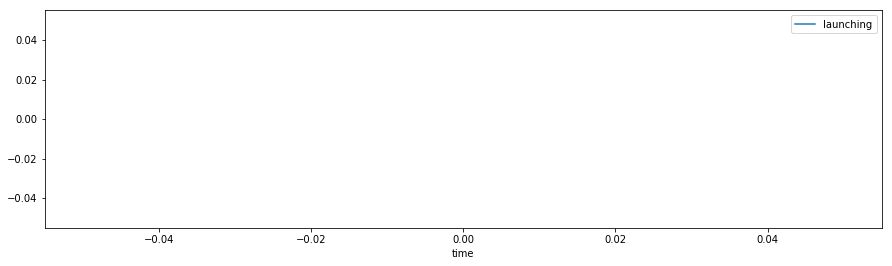

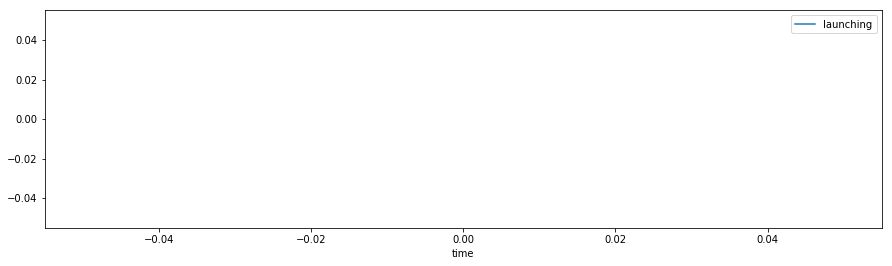

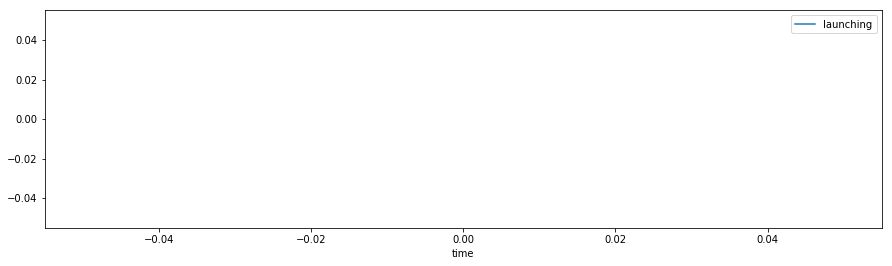

In [38]:
print(group2.title)
DrawCorrectedData(group2, CPU_FREQUENCY_LIMITS, 'min', 0)

### Cpu Idle

The graph to show a min lock status of core Idle.

In [39]:
from systrace_parser import CPU_IDLE
def PreprocessingForCPUIDLE(df):
    try :
        df_launching = df[df.cpu_id == 'launching']
    except :
        df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

        df.loc[df.state >= 4294967295, 'state'] = -1
        df['state'] = df['state'] + 1
        
        return df

    df = pd.concat([df[df.cpu_id == 0], df[df.cpu_id == 4], df[df.cpu_id == 7]])

    df.loc[df.state >= 4294967295, 'state'] = -1
    df['state'] = df['state'] + 1
    
    df = df[df.time >= (df_launching['time'].iloc[0] - 0.1)]
    df = df[df.time <= (df_launching['time'].iloc[1] + 0.1)]
    
    df = pd.concat([df, df_launching])
    return df

1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note


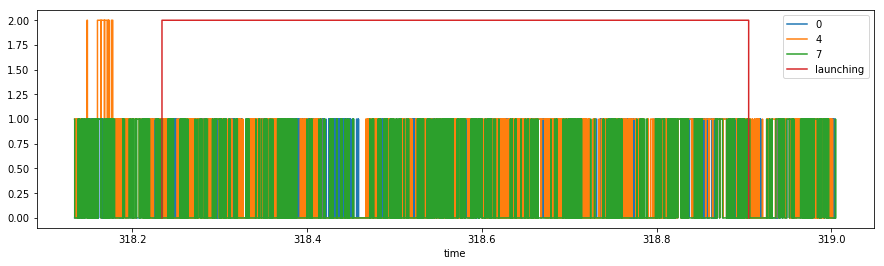

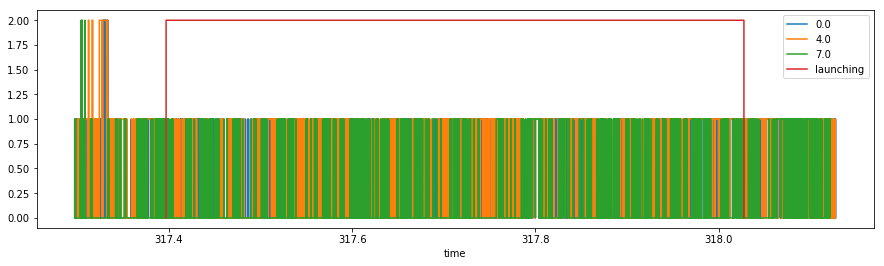

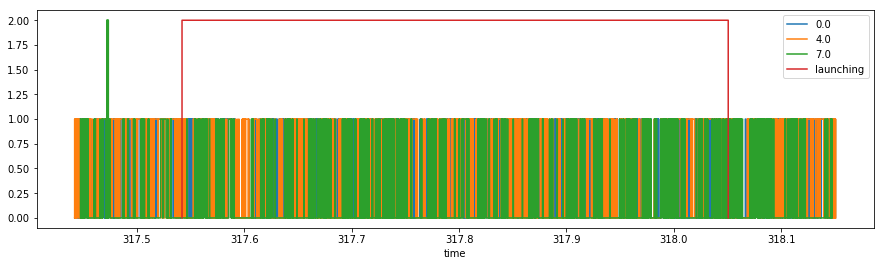

In [40]:
print(group1.title)
DrawCorrectedData(group1, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note


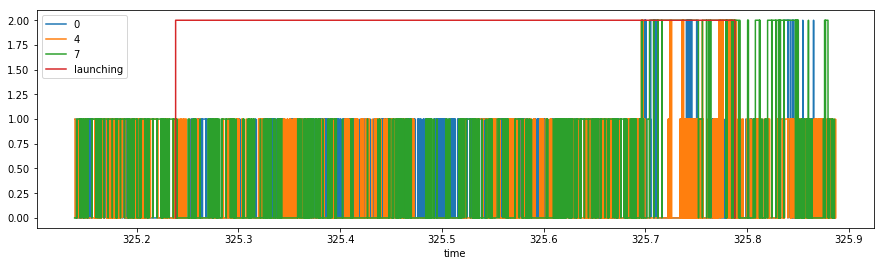

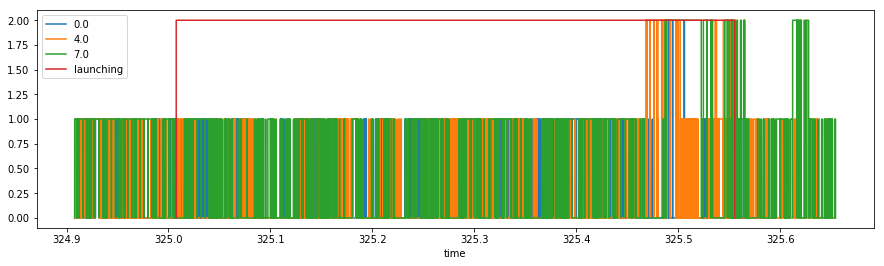

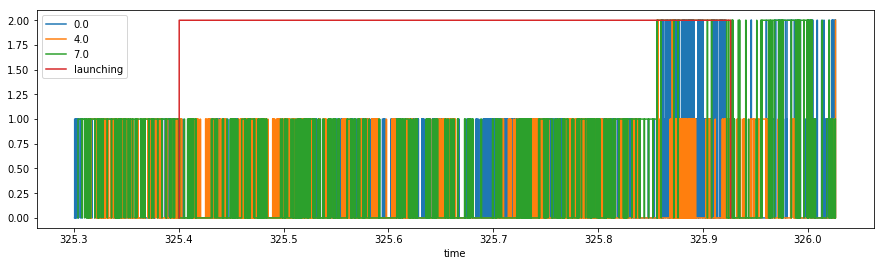

In [41]:
print(group2.title)
DrawCorrectedData(group2, CPU_IDLE, 'state', PreprocessingForCPUIDLE)

### Lock Contention

In [42]:
df1 = group1.get(['lock_contention']) * 1000
df1 = df1.fillna(0)
df1 = df1.round(3)
df1.columns.name = group1.title
#display(df1)

df2 = group2.get(['lock_contention']) * 1000
df2 = df2.fillna(0)
df2 = df2.round(3)
df2.columns.name = group2.title
#display(df2)

df_gap = df1 - df2
df_gap.columns.name = 'DIFF'
#display(df_gap)

In [43]:
display(pd.concat([df1, df2, df_gap], keys=[group1.title, group2.title, 'DIFF'], sort=False))
#display(pd.concat([df1[:1], df2[:1], df_gap[:1]], keys=[group1.title, group2.title, 'DIFF'], sort=False))

,,setSurface,Choreographer #0,Choreographer #1,bindApplication,activityStart,ActivityThreadMain,activityResume,launching
1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note,lock_contention,0,42.643,4.969,4.939,5.174,0.000,2.541,0
1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note,lock_contention,0,9.000,0.000,6.581,9.791,4.991,7.089,0
DIFF,lock_contention,0,33.643,4.969,-1.642,-4.617,-4.991,-4.548,0


In [44]:
def DrawLockContention(parser):
    for lock_contention in parser.storage_lock_contention:
        lock_contention['owner'] = lock_contention['context'].split('owner ')[1].split(' waiters')[0]
        lock_contention['blocking'] = lock_contention['context'].split('blocking from')[1]
    df = DataFrame.from_dict(parser.storage_lock_contention)
    df.loc[df['duration'] > 0, 'duration'] *= 1000

    return df
        #if value == 'NaN':
            
        #else:
        #    display(DataFrame(df[value].value_counts()))

Liminated the lock contentions by the main thread is sleepping in an app.
(The effection means that lock contentions seem to effect to the app entry because the process stat was sleep.)

In [45]:
#for parser in group.parsers_of_testing:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df1 = df[df['effection'] == 'O']
display(group1.title)
display(df1.sort_values(by=['duration'], ascending=False))

u'1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note'

,blocking,context,duration,effection,owner,pid,time,type
9,int com.android.server.wm.MultiTaskingManager...,monitor contention with owner Binder:1236_1C (...,18.374,O,Binder:1236_1C (3895) at void com.android.serv...,1261,318.244212,B
42,void com.android.server.am.ActivityManagerSer...,monitor contention with owner android.display ...,14.967,O,android.display (1261) at void com.android.ser...,1259,318.308945,B
44,android.content.Intent com.android.server.am....,monitor contention with owner android.display ...,8.771,O,android.display (1261) at void com.android.ser...,3112,318.315349,B
92,void com.android.server.wm.ActivityTaskManage...,monitor contention with owner Binder:1236_12 (...,8.108,O,Binder:1236_12 (3112) at void com.android.serv...,1261,318.623448,B
102,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:1236_12 (...,7.691,O,Binder:1236_12 (3112) at int com.android.serve...,1261,318.782169,B
103,void com.android.server.wm.InputMonitor$1.run...,monitor contention with owner Binder:1236_12 (...,6.344,O,Binder:1236_12 (3112) at int com.android.serve...,1262,318.783686,B
13,float com.android.server.wm.WindowManagerServ...,monitor contention with owner Binder:1236_1C (...,6.299,O,Binder:1236_1C (3895) at void com.android.serv...,1262,318.256419,B
20,com.android.server.wm.WindowProcessController...,monitor contention with owner android.display ...,5.946,O,android.display (1261) at boolean com.android....,3112,318.267605,B
15,boolean com.android.server.wm.WindowProcessCo...,monitor contention with owner Binder:1236_1C (...,5.573,O,Binder:1236_1C (3895) at void com.android.serv...,3112,318.257244,B
29,java.util.List com.android.server.wm.Activity...,monitor contention with owner android.display ...,5.447,O,android.display (1261) at void com.android.ser...,1259,318.282492,B


In [46]:
#for parser in group.parsers_of_testing:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df2 = df[df['effection'] == 'O']
display(group2.title)
display(df2.sort_values(by=['duration'], ascending=False))

u'1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note'

,blocking,context,duration,effection,owner,pid,time,type
10,android.app.ContentProviderHolder com.android...,monitor contention with owner android.display ...,24.119,O,android.display (5027) at void com.android.ser...,5201,325.250816,B
11,android.app.ActivityManager$StackInfo com.and...,monitor contention with owner Binder:4970_11 (...,22.647,O,Binder:4970_11 (6823) at void com.android.serv...,5027,325.251284,B
12,float com.android.server.wm.WindowManagerServ...,monitor contention with owner Binder:4970_11 (...,15.153,O,Binder:4970_11 (6823) at void com.android.serv...,5029,325.258959,B
15,android.content.Intent com.android.server.am....,monitor contention with owner android.display ...,14.184,O,android.display (5027) at void com.android.ser...,5598,325.263865,B
103,void com.android.server.wm.ActivityTaskManage...,monitor contention with owner Binder:4970_2 (4...,9.567,O,Binder:4970_2 (4987) at void com.android.serve...,5027,325.587762,B
104,float com.android.server.wm.WindowManagerServ...,monitor contention with owner Binder:4970_2 (4...,7.783,O,Binder:4970_2 (4987) at void com.android.serve...,5201,325.590122,B
81,void com.android.server.wm.TaskChangeNotifica...,monitor contention with owner Binder:4970_2 (4...,6.007,O,Binder:4970_2 (4987) at int com.android.server...,5027,325.372169,B
61,boolean com.android.server.am.ActivityManager...,monitor contention with owner android.display ...,5.778,O,android.display (5027) at void com.android.ser...,4987,325.329004,B
35,void com.android.server.am.ActivityManagerSer...,monitor contention with owner android.display ...,5.147,O,android.display (5027) at void com.android.ser...,4987,325.290075,B
117,void com.android.server.wm.WindowManagerServi...,monitor contention with owner Binder:4970_2 (4...,4.915,O,Binder:4970_2 (4987) at int com.android.server...,5027,325.657719,B


In [47]:
display(group1.title)
display(df1['duration'].sum())

u'1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note'

168.49799999982906

In [48]:
display(group2.title)
display(df2['duration'].sum())

u'1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note'

192.17700000018567

Sum of the lock contention's duration. The durations could be duplicated.

Liminated the lock contentions by owners.

In [49]:
parser = group1.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group1.title)
display(DataFrame(df['owner'].value_counts()))

u'1CAEFvs1EAE_1CAEFTC3_QOS_200304_200304_125444_note'

,owner
android.anim (1262) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:145),6
Binder:1236_5 (1623) at boolean com.android.server.wm.WindowProcessController.hasActivitiesOrRecentTasks()(WindowProcessController.java:631),4
"Binder:1236_12 (3112) at boolean android.os.MessageQueue.enqueueMessage(android.os.Message, long)(MessageQueue.java:556)",4
"FreecessHandler (2473) at void com.android.server.am.freecess.FreecessController.triggerOLAF(java.lang.String, int)(FreecessController.java:1559)",4
"Binder:1236_12 (3112) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2302)",4
android.display (1261) at void com.android.server.wm.WindowManagerService$H.handleMessage(android.os.Message)(WindowManagerService.java:5543),4
android.anim (1262) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:136),3
Binder:1236_1C (3895) at void com.android.server.wm.ActivityTaskManagerService.activityPaused(android.os.IBinder)(ActivityTaskManagerService.java:2449),3
android.anim (1262) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:126),3
"Binder:1236_5 (1623) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2302)",3


In [50]:
parser = group2.parsers_of_testing[0]
df = DrawLockContention(parser)
df = df[df['effection'] == 'O']
display(group2.title)
display(DataFrame(df['owner'].value_counts()))

u'1CAEFvs1EAE_1EAEFTA2_QOS_200117_200117_181416_note'

,owner
"AsyncTask #1 (17163) at void android.content.res.AssetManager.applyStyle(long, int, int, android.content.res.XmlBlock$Parser, int[], long, long)(AssetManager.java:1113)",10
android.anim (5029) at void com.android.server.wm.InputMonitor$1.run()(InputMonitor.java:126),8
"FreecessHandler (6215) at void com.android.server.am.freecess.FreecessController.triggerOLAF(java.lang.String, int)(FreecessController.java:1522)",8
android.anim (5029) at void com.android.server.wm.WindowAnimator.animate(long)(WindowAnimator.java:141),6
"main (17109) at boolean android.content.res.AssetManager.getResourceValue(int, int, android.util.TypedValue, boolean)(AssetManager.java:555)",4
"Binder:4970_2 (4987) at int com.android.server.wm.WindowManagerService.relayoutWindow(com.android.server.wm.Session, android.view.IWindow, int, android.view.WindowManager$LayoutParams, int, int, int, int, long, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.graphics.Rect, android.view.DisplayCutout$ParcelableWrapper, android.util.MergedConfiguration, android.view.SurfaceControl, android.view.InsetsState)(WindowManagerService.java:2249)",4
"android.display (5027) at void com.android.server.am.ActivityManagerService$LocalService.updateActivityUsageStatsWithIntent(android.content.ComponentName, int, int, android.os.IBinder, android.content.ComponentName, android.content.Intent)(ActivityManagerService.java:20528)",3
"android.ui (5019) at android.os.Message com.android.internal.util.function.pooled.PooledLambda.obtainMessage(java.util.function.BiConsumer, java.lang.Object, java.lang.Object)(PooledLambda.java:442)",3
Binder:4970_C (5617) at android.content.pm.UserInfo com.android.server.pm.UserManagerService.getUserInfo(int)(UserManagerService.java:1261),3
Binder:4970_2 (4987) at void com.android.server.wm.RemoteAnimationController.onAnimationFinished()(RemoteAnimationController.java:281),3


Text(0,0.5,'weight')

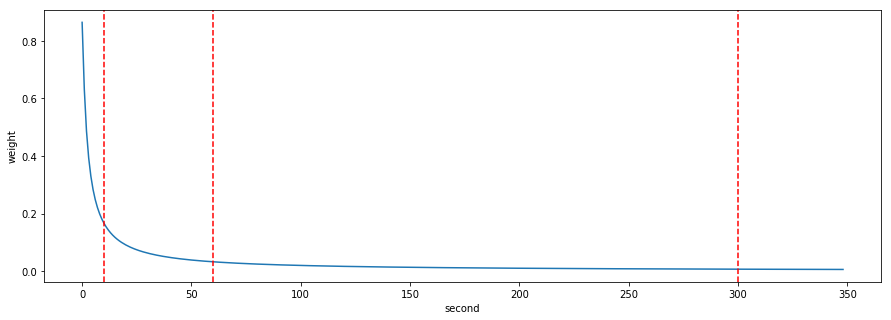

In [51]:
from math import exp


#display(np.exp(-2.0/np.arange(1,300.0)) * 2048)
plt.figure(figsize=(15,5))
plt.plot(1 - np.exp(-2.0/np.arange(1,350.0)))
plt.axvline(x=10, color='r', linestyle='--')
plt.axvline(x=60, color='r', linestyle='--')
plt.axvline(x=300, color='r', linestyle='--')
plt.xlabel('second')
plt.ylabel('weight')